In [1]:
import json, glob, pycm, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from operator import itemgetter
from IPython.display import display, Markdown
from rdflib.plugins.sparql.results.tsvresults import TSVResultParser
from rdflib import URIRef, Graph, Namespace
from rdflib.namespace import RDF, RDFS, OWL
from io import StringIO

In [2]:
def pp_rdf(serialization):
    result_string = "?s\t?p\t?o\n"+serialization
    result_io = StringIO(result_string)
    parser = TSVResultParser()
    parsed_results = parser.parse(result_io)
    g = Graph()
    CLGO = Namespace("http://caligraph.org/ontology/")
    CLGR = Namespace("http://caligraph.org/resource/")
    DBPEDIA = Namespace("http://dbpedia.org/resource/")
    g.bind("clgo", CLGO)
    g.bind("clgr", CLGR)
    g.bind("rdfs", RDFS)
    g.bind("rdf", RDF)
    g.bind("owl", OWL)
    g.bind("dbpedia", DBPEDIA)
    for (s, p, o) in parsed_results:
        s = URIRef(s)
        p = URIRef(p)
        if o.startswith('http'):
            o = URIRef(o)
        g.add((s, p, o))
    return g.serialize(format="ttl")

In [3]:
def display_experiment(experiment):
    display(Markdown(f'## {experiment["concept"]["label"]} ({experiment["concept"]["id"]})'))
    display(Markdown(experiment["concept"]["serialization"]))
    display(Markdown("### Confusion matrix"))
    cm = pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"])
    df_cm = pd.DataFrame(cm.matrix).T.fillna(0)
    ax = sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")
    ax.set_title(experiment["concept"]["label"])
    ax.set(xlabel='LLM', ylabel='KG')
    plt.show()
    df = pd.DataFrame.from_records(experiment["data"])
    df_fp = df[((df["actual"] == 'negative') & (df["predicted"] == 'positive'))][["label", "serialization", "rationale"]]
    if len(df_fp) > 0:
        df_fp_styler = df_fp.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown("### LLM positive, KG negative"))
        display(df_fp_styler)
    df_fn = df[((df["actual"] == 'positive') & (df["predicted"] == 'negative'))][["label", "serialization", "rationale"]]
    if len(df_fn) > 0:
        df_fn_styler = df_fn.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown("### LLM negative, KG positive"))
        display(df_fn_styler)

In [4]:
experiments = [ experiment for experiment in json.load(open('../experiments/caligraph_gpt-4_serialization_results.json', 'r')) if "confusion_matrix" in experiment ]

In [5]:
for experiment in experiments:
    ids = {}
    data = []
    for entity in experiment["data"]:
        if entity['id'] in ids:
            print("Duplicate:", entity['id'])
        else:
            ids[entity['id']] = 1
            data.append(entity)
    experiment["data"] = data
    df_results = pd.DataFrame.from_records(data)
    cm = pycm.ConfusionMatrix(df_results["actual"].tolist(), df_results["predicted"].tolist(), digit=2, classes=[ 'positive', 'negative' ])
    experiment["confusion_matrix"] = cm.matrix

Duplicate: http://caligraph.org/resource/Axel_(singer)
Duplicate: http://caligraph.org/resource/Jos%C3%A9_Andr%C3%A9s_Bilibio
Duplicate: http://caligraph.org/resource/Jos%C3%A9_Andr%C3%A9s_Bilibio
Duplicate: http://caligraph.org/resource/Raquel_Forner
Duplicate: http://caligraph.org/resource/Echternach
Duplicate: http://caligraph.org/resource/Diggstown_(TV_series)
Duplicate: http://caligraph.org/resource/The_Amazing_Race_Canada_2
Duplicate: http://caligraph.org/resource/The_Amazing_Race_Canada_2
Duplicate: http://caligraph.org/resource/The_Amazing_Race_Canada_2
Duplicate: http://caligraph.org/resource/Vecinos_(Colombian_TV_series)
Duplicate: http://caligraph.org/resource/Alliance%20of%20Civilizations_(19963273)
Duplicate: http://caligraph.org/resource/Muhammad_az-Zanati
Duplicate: http://caligraph.org/resource/Goh_Chok_Tong
Duplicate: http://caligraph.org/resource/Richard_Fell
Duplicate: http://caligraph.org/resource/Anton_Rop
Duplicate: http://caligraph.org/resource/Konstantinos_Steph

In [6]:
experiment_df = pd.DataFrame.from_records([ 
    { 
        "name": experiment["concept"]['label'], 
        "kappa": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).Kappa,
        "SOA9": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).SOA9,
        "ACC": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).Overall_ACC,
        "AUC": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).AUC['positive'],
        "F1": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).F1_Macro,
        "FP": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).FP["positive"],
        "FN": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).FN["positive"],
        "POP": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).POP["positive"],
        "experiment": experiment,
    }
    for experiment in experiments if pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).Kappa != 'None' ]).sort_values("kappa", ascending=False)
experiment_df[["name", "kappa", "SOA9", "ACC", "AUC", "F1", "FP", "FN", "POP"]]

,name,kappa,SOA9,ACC,AUC,F1,FP,FN,POP
18,Autobiography,1.000000,High,1.000000,1.000000,1.000000,0,0,40
1,Populated place in Luxembourg,1.000000,High,1.000000,1.000000,1.000000,0,0,39
15,Member of the House of Representatives of Japa...,1.000000,High,1.000000,1.000000,1.000000,0,0,40
3,State leader in 2014,1.000000,High,1.000000,1.000000,1.000000,0,0,32
4,Hill station in India,1.000000,High,1.000000,1.000000,1.000000,0,0,36
13,1748 birth,1.000000,High,1.000000,1.000000,1.000000,0,0,40
7,Medalist at the 2019 Summer Universiade,1.000000,High,1.000000,1.000000,1.000000,0,0,40
10,Player of American football from Alabama,1.000000,High,1.000000,1.000000,1.000000,0,0,33
12,2017 video game,0.950000,High,0.975000,0.975000,0.974984,0,1,40
9,1921 film,0.950000,High,0.975000,0.975000,0.974984,0,1,40


In [7]:
experiment_df.describe()

,kappa,ACC,AUC,F1,FP,FN,POP
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.869156,0.942666,0.933297,0.930169,1.157895,0.947368,37.631579
std,0.221466,0.086119,0.114027,0.123591,3.023301,1.614988,3.419073
min,0.147059,0.724138,0.555556,0.516667,0.000000,0.000000,29.000000
25%,0.840678,0.921429,0.916667,0.919733,0.000000,0.000000,35.500000
50%,0.950000,0.975000,0.975000,0.974984,0.000000,0.000000,40.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,40.000000
max,1.000000,1.000000,1.000000,1.000000,11.000000,5.000000,40.000000


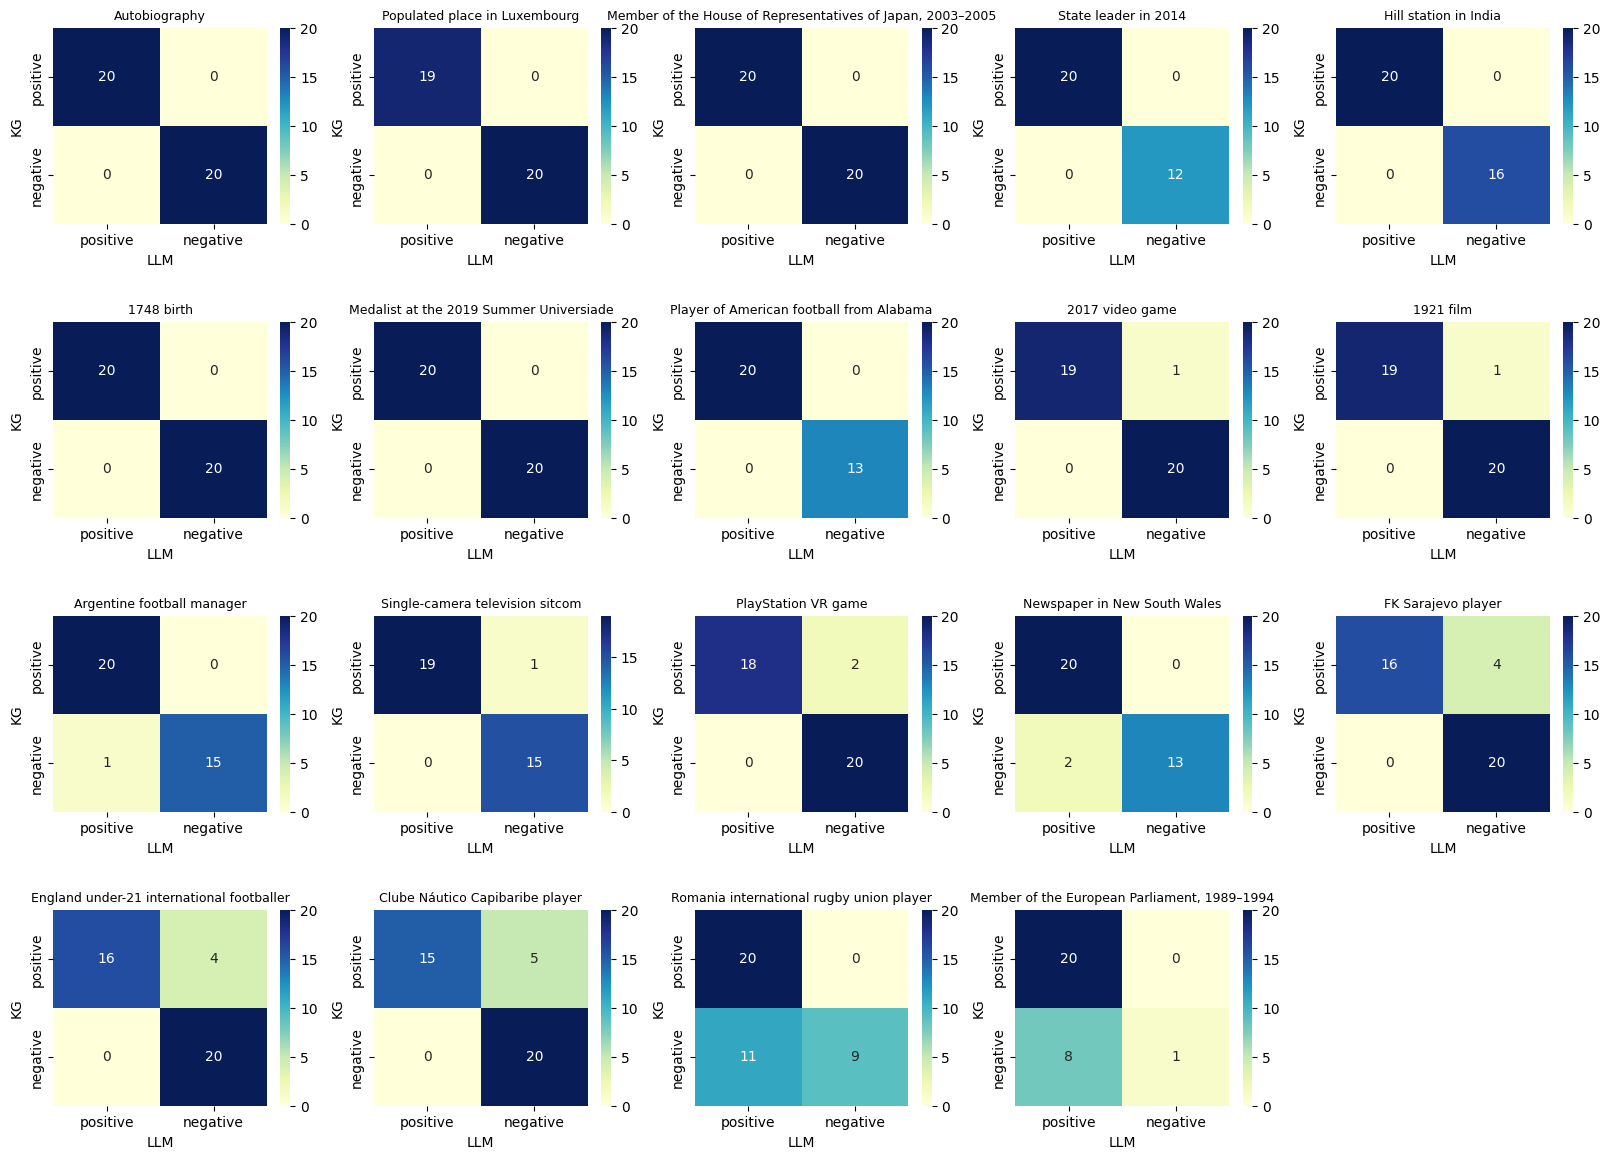

In [8]:
fig = plt.figure(figsize=(20,14))
gs = fig.add_gridspec(4, 5, hspace=0.5)
axes = gs.subplots()
cms = [ (experiment["name"], pycm.ConfusionMatrix(matrix=experiment["experiment"]["confusion_matrix"])) for experiment in experiment_df.to_dict('records')  ]
for ax, (name, cm) in zip(axes.flat, cms):
    df = pd.DataFrame(cm.matrix).T.fillna(0)
    sns.heatmap(df, annot=True, fmt='d', cmap="YlGnBu", ax=ax)
    ax.set_title(name, wrap=True, fontsize=9)
    ax.set(xlabel='LLM', ylabel='KG')
for ax in axes.flat[len(cms):]:
    ax.set_visible(False)
plt.show()

## Autobiography (http://caligraph.org/ontology/Autobiography)

"http://caligraph.org/ontology/Autobiography"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/Autobiography"	"http://www.w3.org/2000/01/rdf-schema#label"	"Autobiography"
"http://caligraph.org/ontology/Autobiography"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Biography_(books)"
"http://caligraph.org/ontology/Autobiography"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:Autobiographies"
"http://caligraph.org/ontology/Autobiography"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:Autobiographies_by_nationality"
"http://caligraph.org/ontology/Autobiography"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/List_of_autobiographies"
"http://caligraph.org/resource/Only%20Fools%20and%20Stories_(19487079)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Autobiography"
"http://caligraph.org/resource/Tall,%20Dark%20&%20Gruesome_(19498068)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Autobiography"
"http://caligraph.org/resource/Humble%20Pie_(19748147)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Autobiography"
"http://caligraph.org/resource/I%20Flew%20for%20the%20F%C3%BChrer_(19766362)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Autobiography"
"http://caligraph.org/resource/Joys%20and%20Sorrows:%20Reflections_(19754599)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Autobiography"
"http://caligraph.org/resource/Lessons%20From%20a%20Life%20in%20Feathers_(19774035)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Autobiography"
"http://caligraph.org/resource/:%20The%20Autobiography%20of%20Nikola%20Tesla_(19964837)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Autobiography"
"http://caligraph.org/resource/Visibility%20Unlimited_(19949604)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Autobiography"
"http://caligraph.org/resource/WHAM!,%20George%20Michael,%20&%20Me_(19979593)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Autobiography"
"http://caligraph.org/resource/Do%20You%20Want%20to%20Go%20With%20Me%3F%22%20(Willst%20du%20mit%20mir%20gehn_(24366755)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Autobiography"
"http://caligraph.org/resource/And_the_Beat_Goes_On_(The_Whispers_song)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Autobiography"
"http://caligraph.org/resource/Anna_Sui_(2009_book)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Autobiography"
"http://caligraph.org/resource/Nine_Lives_(2005_film)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Autobiography"
"http://caligraph.org/resource/The_Land_I_Lost"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Autobiography"


### Confusion matrix

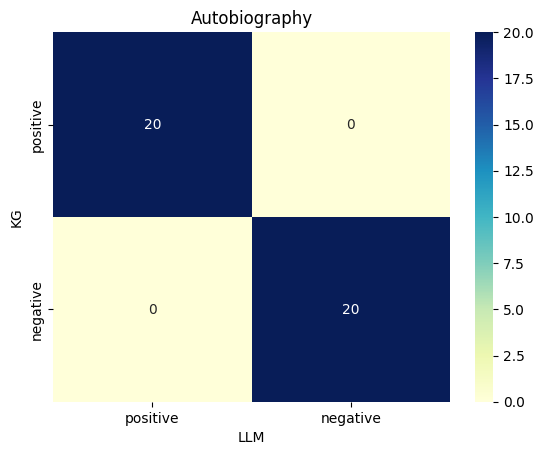

## Populated place in Luxembourg (http://caligraph.org/ontology/Populated_place_in_Luxembourg)

"http://caligraph.org/ontology/Populated_place_in_Luxembourg"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/Populated_place_in_Luxembourg"	"http://www.w3.org/2000/01/rdf-schema#label"	"Populated place in Luxembourg"
"http://caligraph.org/ontology/Populated_place_in_Luxembourg"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Populated_place_in_Europe"
"http://caligraph.org/ontology/Populated_place_in_Luxembourg"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:Populated_places_in_Luxembourg"
"http://caligraph.org/ontology/Populated_place_in_Luxembourg"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/List_of_populated_places_in_Luxembourg"
"http://caligraph.org/resource/Bleesmillen_(19500076)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Populated_place_in_Luxembourg"
"http://caligraph.org/resource/Hemstal_(19500778)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Populated_place_in_Luxembourg"
"http://caligraph.org/resource/Pafebruch_(19764711)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Populated_place_in_Luxembourg"
"http://caligraph.org/resource/Simmerfarm_(19759809)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Populated_place_in_Luxembourg"
"http://caligraph.org/resource/L%C3%B6ftgermillen_(19981928)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Populated_place_in_Luxembourg"
"http://caligraph.org/resource/Cents,_Luxembourg"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Populated_place_in_Luxembourg"
"http://caligraph.org/resource/Schwebach"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Populated_place_in_Luxembourg"
"http://caligraph.org/resource/Kaesfurt_(17178379)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Populated_place_in_Luxembourg"
"http://caligraph.org/resource/Neum%C3%BChle_(17273401)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Populated_place_in_Luxembourg"
"http://caligraph.org/resource/Theinshaff_(17434441)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Populated_place_in_Luxembourg"
"http://caligraph.org/resource/Kohnenhaff_(18547048)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Populated_place_in_Luxembourg"
"http://caligraph.org/resource/Stoppelhaff_(18549892)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Populated_place_in_Luxembourg"
"http://caligraph.org/resource/Heisbich_(18973008)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Populated_place_in_Luxembourg"
"http://caligraph.org/resource/Lauterborn_(18980569)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Populated_place_in_Luxembourg"
"http://caligraph.org/resource/F%C3%A9ischterbierg_(19066717)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Populated_place_in_Luxembourg"


### Confusion matrix

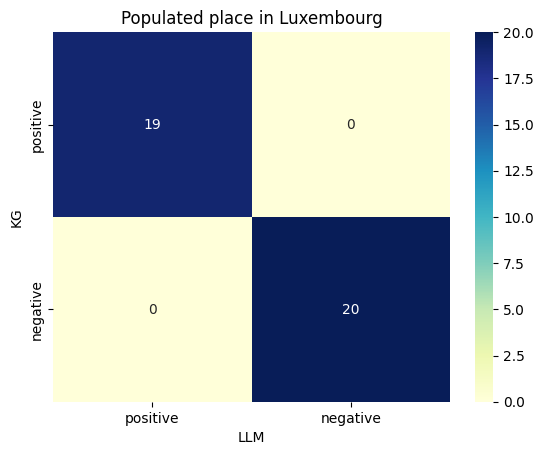

## Member of the House of Representatives of Japan, 2003–2005 (http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005)

"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"	"http://www.w3.org/2000/01/rdf-schema#label"	"Member of the House of Representatives of Japan, 2003–2005"
"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://www.w3.org/2002/07/owl#Thing"
"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/List_of_members_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"
"http://caligraph.org/resource/Ikuo%20Horigome_(19468425)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"
"http://caligraph.org/resource/Kinya%20Narazaki_(19485180)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"
"http://caligraph.org/resource/Miyoko%20Hida_(19491399)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"
"http://caligraph.org/resource/Takashi%20Aoyama_(19467947)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"
"http://caligraph.org/resource/Kenji_Kosaka"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"
"http://caligraph.org/resource/Yoshir%C5%8D_Mori"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"
"http://caligraph.org/resource/Kenji_Kobayashi"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"
"http://caligraph.org/resource/Ren_Sato"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"
"http://caligraph.org/resource/Sadakazu_Tanigaki"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"
"http://caligraph.org/resource/Tadahiro_Matsushita"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"
"http://caligraph.org/resource/Yasuko_Ikenob%C5%8D"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"
"http://caligraph.org/resource/Yuriko_Koike"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"
"http://caligraph.org/resource/Kansei_Nakano"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"
"http://caligraph.org/resource/Koichi_Takemasa"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"
"http://caligraph.org/resource/Kenichi_Mizuno"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"
"http://caligraph.org/resource/Masashi_Nakano"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_House_of_Representatives_of_Japan,_2003%E2%80%932005"


### Confusion matrix

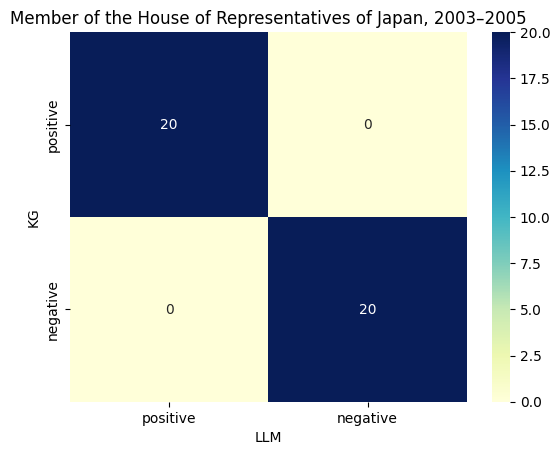

## State leader in 2014 (http://caligraph.org/ontology/State_leader_in_2014)

"http://caligraph.org/ontology/State_leader_in_2014"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/State_leader_in_2014"	"http://www.w3.org/2000/01/rdf-schema#label"	"State leader in 2014"
"http://caligraph.org/ontology/State_leader_in_2014"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/State_leader"
"http://caligraph.org/ontology/State_leader_in_2014"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/List_of_state_leaders_in_2014"
"http://caligraph.org/resource/%CA%BBAkilisi_P%C5%8Dhiva"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/State_leader_in_2014"
"http://caligraph.org/resource/Armando_Guebuza"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/State_leader_in_2014"
"http://caligraph.org/resource/Barry_Haase"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/State_leader_in_2014"
"http://caligraph.org/resource/Hovik_Abrahamyan"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/State_leader_in_2014"
"http://caligraph.org/resource/Michael_Dunkley"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/State_leader_in_2014"
"http://caligraph.org/resource/Milo%C5%A1_Zeman"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/State_leader_in_2014"
"http://caligraph.org/resource/Nicos_Anastasiades"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/State_leader_in_2014"
"http://caligraph.org/resource/Omar_al-Hassi"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/State_leader_in_2014"
"http://caligraph.org/resource/Tsakhiagiin_Elbegdorj"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/State_leader_in_2014"
"http://caligraph.org/resource/Adam_Wood"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/State_leader_in_2014"
"http://caligraph.org/resource/Beji_Caid_Essebsi"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/State_leader_in_2014"
"http://caligraph.org/resource/Harold_Martin_(New_Caledonian_politician)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/State_leader_in_2014"
"http://caligraph.org/resource/Jorge_Carlos_Fonseca"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/State_leader_in_2014"
"http://caligraph.org/resource/Joyce_Banda"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/State_leader_in_2014"
"http://caligraph.org/resource/Mikhail_Myasnikovich"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/State_leader_in_2014"
"http://caligraph.org/resource/Hassan_Rouhani"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/State_leader_in_2014"


### Confusion matrix

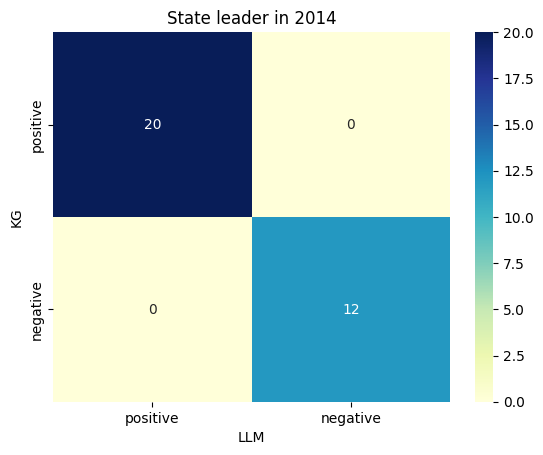

## Hill station in India (http://caligraph.org/ontology/Hill_station_in_India)

"http://caligraph.org/ontology/Hill_station_in_India"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/Hill_station_in_India"	"http://www.w3.org/2000/01/rdf-schema#label"	"Hill station in India"
"http://caligraph.org/ontology/Hill_station_in_India"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Place_in_India"
"http://caligraph.org/ontology/Hill_station_in_India"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Hill_station"
"http://caligraph.org/ontology/Hill_station_in_India"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/RestrictionHasValue_country_India"
"http://caligraph.org/ontology/Hill_station_in_India"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/List_of_hill_stations_in_India"
"http://caligraph.org/ontology/Hill_station_in_India"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:Hill_stations_in_India"
"http://caligraph.org/ontology/Hill_station_in_India"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:Hill_stations_in_India_by_state_or_union_territory"
"http://caligraph.org/resource/Kakkadampoyil"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Hill_station_in_India"
"http://caligraph.org/resource/Noney"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Hill_station_in_India"
"http://caligraph.org/resource/Ganjam_district"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Hill_station_in_India"
"http://caligraph.org/resource/Koraput"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Hill_station_in_India"
"http://caligraph.org/resource/Navamalai"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Hill_station_in_India"
"http://caligraph.org/resource/Mothugudem"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Hill_station_in_India"
"http://caligraph.org/resource/Naneghat"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Hill_station_in_India"
"http://caligraph.org/resource/Chathurangapara"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Hill_station_in_India"
"http://caligraph.org/resource/Manjampatti_Valley"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Hill_station_in_India"
"http://caligraph.org/resource/Mannavanur"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Hill_station_in_India"
"http://caligraph.org/resource/Nidh_(17182649)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Hill_station_in_India"
"http://caligraph.org/resource/Puthur_(17188693)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Hill_station_in_India"


### Confusion matrix

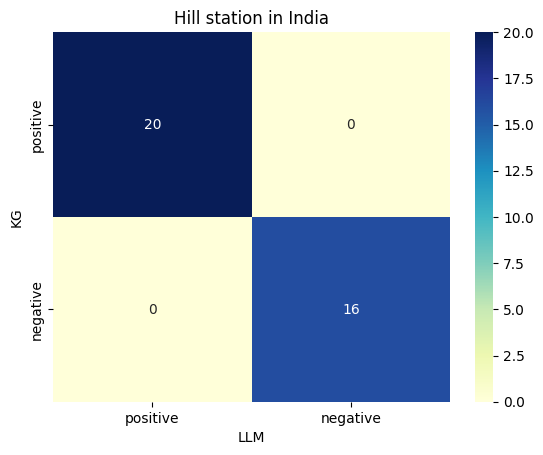

## 1748 birth (http://caligraph.org/ontology/1748_birth)

"http://caligraph.org/ontology/1748_birth"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/1748_birth"	"http://www.w3.org/2000/01/rdf-schema#label"	"1748 birth"
"http://caligraph.org/ontology/1748_birth"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/RestrictionHasValue_birthYear_1748"
"http://caligraph.org/ontology/1748_birth"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/1740s_birth"
"http://caligraph.org/ontology/1748_birth"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:1748_births"
"http://caligraph.org/resource/August_Friedrich_Pfeiffer"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1748_birth"
"http://caligraph.org/resource/Francisco_Javier_Mier_Campillo"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1748_birth"
"http://caligraph.org/resource/Philippe_I_Louis_van_de_Werve,_1st_Baron_of_Schilde"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1748_birth"
"http://caligraph.org/resource/Thomas_Johnes"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1748_birth"
"http://caligraph.org/resource/William_Holbech_(MP)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1748_birth"
"http://caligraph.org/resource/Antoine_Graincourt"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1748_birth"
"http://caligraph.org/resource/Henry_Sherburne_(colonel)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1748_birth"
"http://caligraph.org/resource/Maximilian_von_Alopaeus"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1748_birth"
"http://caligraph.org/resource/Francesco_Azopardi"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1748_birth"
"http://caligraph.org/resource/Hugh_Henry_Brackenridge"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1748_birth"
"http://caligraph.org/resource/Jos%C3%A9_Lid%C3%B3n"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1748_birth"
"http://caligraph.org/resource/John_Ramage_(artist)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1748_birth"
"http://caligraph.org/resource/Patrick_Craufurd_Bruce"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1748_birth"
"http://caligraph.org/resource/Gilbert_Rodman_(born_1748)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1748_birth"
"http://caligraph.org/resource/Jeremiah_Chase"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1748_birth"


### Confusion matrix

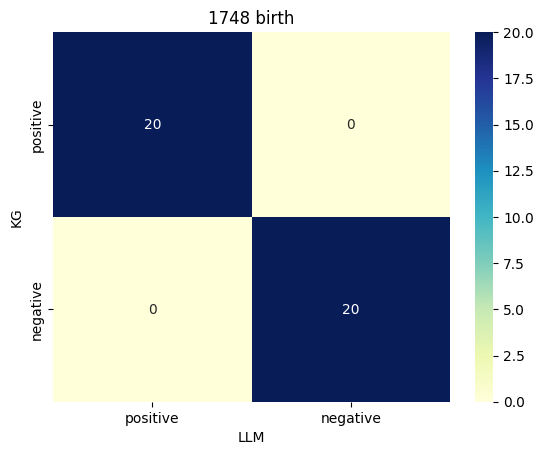

## Medalist at the 2019 Summer Universiade (http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade)

"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"	"http://www.w3.org/2000/01/rdf-schema#label"	"Medalist at the 2019 Summer Universiade"
"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Athlete"
"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:Medalists_at_the_2019_Summer_Universiade"
"http://caligraph.org/resource/Lauren_Scherf"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"
"http://caligraph.org/resource/Ben_Broeders"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"
"http://caligraph.org/resource/Lara_McSpadden"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"
"http://caligraph.org/resource/Liveta_Jasi%C5%ABnait%C4%97"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"
"http://caligraph.org/resource/Nana_Adoma_Owusu-Afriyie"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"
"http://caligraph.org/resource/Yann_Randrianasolo"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"
"http://caligraph.org/resource/Dean_Farris"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"
"http://caligraph.org/resource/J%C3%BAlio_Ferreira"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"
"http://caligraph.org/resource/Lee_Pei-chi"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"
"http://caligraph.org/resource/Guillaume_Bianchi"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"
"http://caligraph.org/resource/Yang_Kun-pi"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"
"http://caligraph.org/resource/Alessia_Russo_(gymnast)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"
"http://caligraph.org/resource/Ren%C3%A9e_Lucht"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"
"http://caligraph.org/resource/Sung_Hyang-sim"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"
"http://caligraph.org/resource/Tang_Chia-hung"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"
"http://caligraph.org/resource/Yu_Ziyang"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Medalist_at_the_2019_Summer_Universiade"


### Confusion matrix

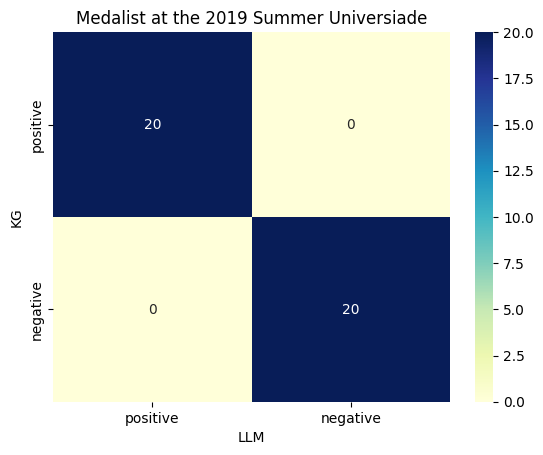

## Player of American football from Alabama (http://caligraph.org/ontology/Player_of_American_football_from_Alabama)

"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"	"http://www.w3.org/2000/01/rdf-schema#label"	"Player of American football from Alabama"
"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/American_player_of_American_football"
"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/American_football_person_from_Alabama"
"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:Players_of_American_football_from_Alabama"
"http://caligraph.org/resource/Brendan%20Burgdorf_(19477971)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"
"http://caligraph.org/resource/Anthony_Redmon"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"
"http://caligraph.org/resource/Cadillac_Williams"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"
"http://caligraph.org/resource/Casey_Dunn_(American_football)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"
"http://caligraph.org/resource/Chucky_Mullins"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"
"http://caligraph.org/resource/Gordon_Holmes_(American_football)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"
"http://caligraph.org/resource/Richmond_Flowers_Jr."	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"
"http://caligraph.org/resource/Sammie_Coates"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"
"http://caligraph.org/resource/Vince_Dooley"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"
"http://caligraph.org/resource/Ellis_Lankster"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"
"http://caligraph.org/resource/J._D._McKissic"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"
"http://caligraph.org/resource/Richard_Williamson_(American_football)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"
"http://caligraph.org/resource/Tytus_Howard"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"
"http://caligraph.org/resource/Henry_Williams_(American_football)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"
"http://caligraph.org/resource/Jimmie_Ward"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Player_of_American_football_from_Alabama"


### Confusion matrix

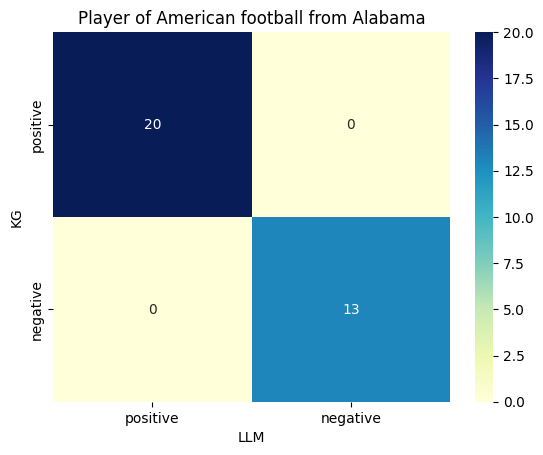

## 2017 video game (http://caligraph.org/ontology/2017_video_game)

"http://caligraph.org/ontology/2017_video_game"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/2017_video_game"	"http://www.w3.org/2000/01/rdf-schema#label"	"2017 video game"
"http://caligraph.org/ontology/2017_video_game"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/The_art"
"http://caligraph.org/ontology/2017_video_game"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Video_game"
"http://caligraph.org/ontology/2017_video_game"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:2017_video_games"
"http://caligraph.org/resource/Our_World_is_Ended"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/2017_video_game"
"http://caligraph.org/resource/Atomega"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/2017_video_game"
"http://caligraph.org/resource/Final_Fantasy_XV"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/2017_video_game"
"http://caligraph.org/resource/Fortnite"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/2017_video_game"
"http://caligraph.org/resource/Hiveswap"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/2017_video_game"
"http://caligraph.org/resource/Road_Rage_(video_game)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/2017_video_game"
"http://caligraph.org/resource/Buck_(video_game)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/2017_video_game"
"http://caligraph.org/resource/Football_Manager_2018"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/2017_video_game"
"http://caligraph.org/resource/Blackwood_Crossing"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/2017_video_game"
"http://caligraph.org/resource/DJMax_Respect"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/2017_video_game"
"http://caligraph.org/resource/Fire_Pro_Wrestling_World"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/2017_video_game"
"http://caligraph.org/resource/Sundered"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/2017_video_game"
"http://caligraph.org/resource/Creeping_Terror_(video_game)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/2017_video_game"
"http://caligraph.org/resource/DeadTruth:_The_Dark_Path_Ahead"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/2017_video_game"
"http://caligraph.org/resource/Puzzle_Fighter_(2017_video_game)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/2017_video_game"


### Confusion matrix

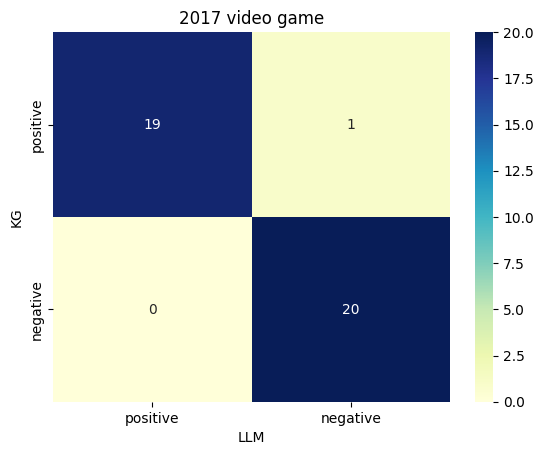

### LLM negative, KG positive

label,serialization,rationale
Wolfenstein II: The New Colossus,"""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_about_Nazis"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Experimental_medical_treatment_in_fiction"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_set_in_Texas"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_set_in_Washington,_D.C."" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_scored_by_Mick_Gordon"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_set_in_New_Mexico"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_set_in_Los_Angeles"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_set_in_1961"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_set_on_Venus"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_set_in_Alaska"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_set_in_Kansas"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Retrofuturistic_video_game"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_set_on_the_Moon"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://www.w3.org/2002/07/owl#NamedIndividual"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Action-adventure_game"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Alternate_history_fiction"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Bethesda_Softworks_video_game"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Film"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/First-person_shooter"" ""http://caligraph.org/resource/Wolfenstein_II:_The_New_Colossus"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Movie""","The provided definition does not include any information that directly links the entity Wolfenstein II: The New Colossus to the concept of a 2017 video game. Therefore, based solely on the given definition, it cannot be argued that Wolfenstein II: The New Colossus is a 2017 video game."


## 1921 film (http://caligraph.org/ontology/1921_film)

"http://caligraph.org/ontology/1921_film"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/1921_film"	"http://www.w3.org/2000/01/rdf-schema#label"	"1921 film"
"http://caligraph.org/ontology/1921_film"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Movie"
"http://caligraph.org/ontology/1921_film"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Upcoming_film"
"http://caligraph.org/ontology/1921_film"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:1921_films"
"http://caligraph.org/ontology/1921_film"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:Lists_of_1921_films_by_country_or_language"
"http://caligraph.org/resource/Lavender_and_Old_Lace_(film)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1921_film"
"http://caligraph.org/resource/Mated_in_the_Wilds"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1921_film"
"http://caligraph.org/resource/The_Home_Stretch"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1921_film"
"http://caligraph.org/resource/The_Whistle_(film)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1921_film"
"http://caligraph.org/resource/A_Lowland_Cinderella"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1921_film"
"http://caligraph.org/resource/Alias_Ladyfingers"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1921_film"
"http://caligraph.org/resource/General_Post"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1921_film"
"http://caligraph.org/resource/Hold_Your_Horses_(film)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1921_film"
"http://caligraph.org/resource/No_Defense_(1921_film)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1921_film"
"http://caligraph.org/resource/School_Days_(1921_film)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1921_film"
"http://caligraph.org/resource/The_Bell_Hop"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1921_film"
"http://caligraph.org/resource/The_Films_of_Princess_Fantoche"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1921_film"
"http://caligraph.org/resource/The_Flat_(1921_film)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1921_film"
"http://caligraph.org/resource/The_Golden_Snare"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/1921_film"


### Confusion matrix

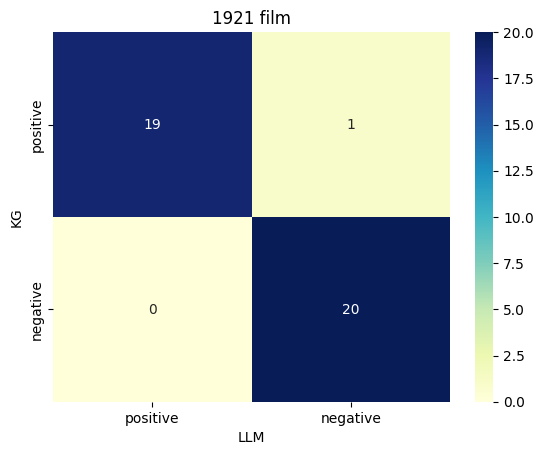

### LLM negative, KG positive

label,serialization,rationale
Miss Charity,"""http://caligraph.org/resource/Miss_Charity"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/British_film_of_1921"" ""http://caligraph.org/resource/Miss_Charity"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Film_directed_by_Edwin_J._Collins"" ""http://caligraph.org/resource/Miss_Charity"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://www.w3.org/2002/07/owl#NamedIndividual"" ""http://caligraph.org/resource/Miss_Charity"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/1920s_English-language_film"" ""http://caligraph.org/resource/Miss_Charity"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/1920s_romance_film"" ""http://caligraph.org/resource/Miss_Charity"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/British_black-and-white_film"" ""http://caligraph.org/resource/Miss_Charity"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/British_romance_film"" ""http://caligraph.org/resource/Miss_Charity"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/British_silent_feature_film"" ""http://caligraph.org/resource/Miss_Charity"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Film_based_on_British_novels"" ""http://caligraph.org/resource/Miss_Charity"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Butcher's_Film_Service_film"" ""http://caligraph.org/resource/Miss_Charity"" ""http://www.w3.org/2000/01/rdf-schema#label"" ""Miss Charity"" ""http://caligraph.org/resource/Miss_Charity"" ""http://www.w3.org/2002/07/owl#sameAs"" ""http://dbpedia.org/resource/Miss_Charity"" ""http://caligraph.org/resource/Miss_Charity"" ""http://www.w3.org/2004/02/skos/core#prefLabel"" ""Miss Charity"" ""http://caligraph.org/resource/Miss_Charity"" ""http://caligraph.org/ontology/director"" ""http://caligraph.org/resource/Edwin_J._Collins"" ""http://caligraph.org/resource/Miss_Charity"" ""http://caligraph.org/ontology/distributor"" ""http://caligraph.org/resource/Butcher's_Film_Service"" ""http://caligraph.org/resource/Miss_Charity"" ""http://caligraph.org/ontology/language"" ""http://caligraph.org/resource/Intertitle"" ""http://caligraph.org/resource/Miss_Charity"" ""http://caligraph.org/ontology/language"" ""http://caligraph.org/resource/Silent_film"" ""http://caligraph.org/resource/Miss_Charity"" ""http://caligraph.org/ontology/occupation"" ""http://caligraph.org/resource/Film_director"" ""http://caligraph.org/resource/Miss_Charity"" ""http://caligraph.org/ontology/productionCompany"" ""http://caligraph.org/resource/Butcher's_Film_Service"" ""http://caligraph.org/resource/Miss_Charity"" ""http://caligraph.org/ontology/starring"" ""http://caligraph.org/resource/Dick_Webb""","The concept definition of ""1921 film"" does not explicitly include ""Miss Charity"" as an instance. However, ""Miss Charity"" is defined as a ""British film of 1921"", which suggests that it was a film produced in the year 1921. Therefore, based on the temporal aspect of the concept definition, one could argue that ""Miss Charity"" falls under the category of ""1921 film"". However, without explicit linking or subclass information connecting ""British film of 1921"" to ""1921 film"", this assertion is based on inference and not directly supported by the provided definitions."


## Argentine football manager (http://caligraph.org/ontology/Argentine_football_manager)

"http://caligraph.org/ontology/Argentine_football_manager"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/Argentine_football_manager"	"http://www.w3.org/2000/01/rdf-schema#label"	"Argentine football manager"
"http://caligraph.org/ontology/Argentine_football_manager"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Argentine_sports_coach"
"http://caligraph.org/ontology/Argentine_football_manager"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Football_manager_in_Argentina"
"http://caligraph.org/ontology/Argentine_football_manager"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/RestrictionHasValue_birthPlace_Argentina"
"http://caligraph.org/ontology/Argentine_football_manager"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:Argentine_football_managers"
"http://caligraph.org/resource/Horacio_Bongiovanni"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Argentine_football_manager"
"http://caligraph.org/resource/Jos%C3%A9_Garc%C3%ADa_P%C3%A9rez"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Argentine_football_manager"
"http://caligraph.org/resource/Jos%C3%A9_Varacka"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Argentine_football_manager"
"http://caligraph.org/resource/Lucas_Ochandorena"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Argentine_football_manager"
"http://caligraph.org/resource/Hector_Alfredo_D'Angelo"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Argentine_football_manager"
"http://caligraph.org/resource/Juan_Brown"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Argentine_football_manager"
"http://caligraph.org/resource/Juan_Quarterone"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Argentine_football_manager"
"http://caligraph.org/resource/Rub%C3%A9n_Dar%C3%ADo_Ins%C3%BAa"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Argentine_football_manager"
"http://caligraph.org/resource/Juan_Carlos_Sarnari"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Argentine_football_manager"
"http://caligraph.org/resource/Mauro_Navas"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Argentine_football_manager"
"http://caligraph.org/resource/H%C3%A9ctor_Rial"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Argentine_football_manager"
"http://caligraph.org/resource/Iv%C3%A1n_Sopegno"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Argentine_football_manager"
"http://caligraph.org/resource/Marcelo_Trobbiani"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Argentine_football_manager"
"http://caligraph.org/resource/Rodolfo_Motta"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Argentine_football_manager"


### Confusion matrix

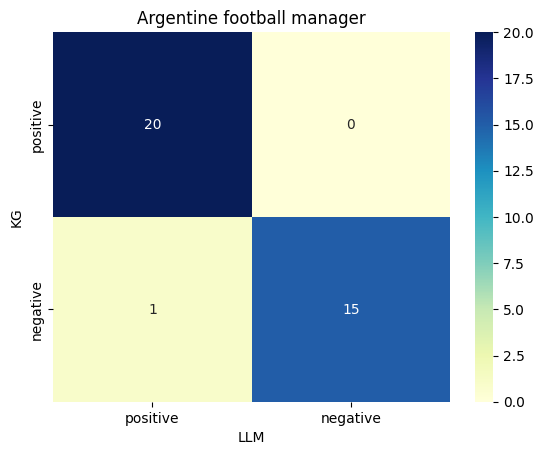

### LLM positive, KG negative

label,serialization,rationale
Héctor Gabriel Morales,"""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Argentine_expatriate_sportsperson_in_Hungary"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Person_from_Corrientes"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Sportsperson_from_Corrientes_Province"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://www.w3.org/2002/07/owl#NamedIndividual"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/1989_birth"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Argentine_expatriate_footballer"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Association_football_manager"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Estudiantes_de_La_Plata_footballer"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Expatriate_footballer_in_Hungary"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Ferencv%C3%A1rosi_TC_footballer"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Living_person"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Expatriate_footballer_in_Honduras"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Foreign_Honduran_Liga_Nacional_player"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/C.D._Victoria_player"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/2000/01/rdf-schema#label"" ""Héctor Gabriel Morales"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/2002/07/owl#sameAs"" ""http://dbpedia.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/2004/02/skos/core#prefLabel"" ""Héctor Gabriel Morales"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/2004/02/skos/core#altLabel"" ""Morales"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/2004/02/skos/core#altLabel"" ""H. Morales"" ""http://caligraph.org/resource/H%C3%A9ctor_Gabriel_Morales"" ""http://www.w3.org/2004/02/skos/core#altLabel"" ""Hector Morales""","Héctor Gabriel Morales is classified under the type ""http://caligraph.org/ontology/Association_football_manager"", which is a general term for a football manager. Additionally, he is also classified under ""http://caligraph.org/ontology/Argentine_expatriate_footballer"", indicating that he is from Argentina and has been involved in football. Therefore, using the given definition of an Argentine football manager, it can be argued that Héctor Gabriel Morales fits this category."


## Single-camera television sitcom (http://caligraph.org/ontology/Single-camera_television_sitcom)

"http://caligraph.org/ontology/Single-camera_television_sitcom"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/Single-camera_television_sitcom"	"http://www.w3.org/2000/01/rdf-schema#label"	"Single-camera television sitcom"
"http://caligraph.org/ontology/Single-camera_television_sitcom"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Television_show"
"http://caligraph.org/ontology/Single-camera_television_sitcom"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Sitcom"
"http://caligraph.org/ontology/Single-camera_television_sitcom"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:Single-camera_television_sitcoms"
"http://caligraph.org/ontology/Single-camera_television_sitcom"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/List_of_single-camera_situation_comedies"
"http://caligraph.org/resource/Great_News"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Single-camera_television_sitcom"
"http://caligraph.org/resource/The_Patty_Duke_Show"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Single-camera_television_sitcom"
"http://caligraph.org/resource/The_Smothers_Brothers_Show"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Single-camera_television_sitcom"
"http://caligraph.org/resource/Blandings_(TV_series)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Single-camera_television_sitcom"
"http://caligraph.org/resource/Kaya_(TV_series)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Single-camera_television_sitcom"
"http://caligraph.org/resource/N%C3%A6turvaktin"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Single-camera_television_sitcom"
"http://caligraph.org/resource/Cooper_Barrett's_Guide_to_Surviving_Life"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Single-camera_television_sitcom"
"http://caligraph.org/resource/Hatching,_Matching_and_Dispatching"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Single-camera_television_sitcom"
"http://caligraph.org/resource/Head_Case"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Single-camera_television_sitcom"
"http://caligraph.org/resource/Lockie_Leonard_(TV_series)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Single-camera_television_sitcom"
"http://caligraph.org/resource/Tabitha_(TV_series)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Single-camera_television_sitcom"
"http://caligraph.org/resource/Andi_Mack"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Single-camera_television_sitcom"
"http://caligraph.org/resource/Black-ish"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Single-camera_television_sitcom"
"http://caligraph.org/resource/Powerless_(TV_series)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Single-camera_television_sitcom"


### Confusion matrix

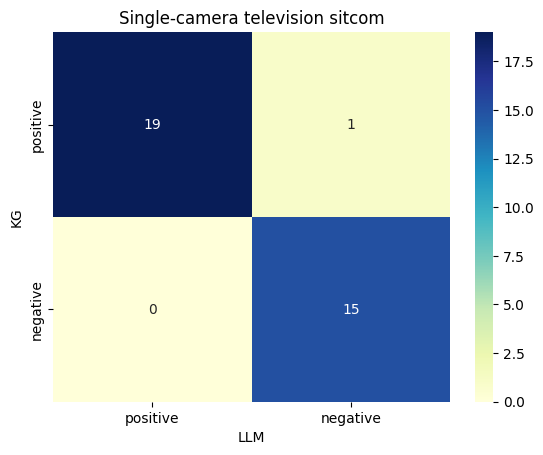

### LLM negative, KG positive

label,serialization,rationale
Leap of Faith (TV series),"""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/2000s_American_single-camera_sitcom"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://www.w3.org/2002/07/owl#NamedIndividual"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Movie"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/The_art"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Upcoming_film"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://www.w3.org/2000/01/rdf-schema#label"" ""Leap of Faith (TV series)"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://www.w3.org/2002/07/owl#sameAs"" ""http://dbpedia.org/resource/Leap_of_Faith_(TV_series)"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://www.w3.org/2004/02/skos/core#prefLabel"" ""Leap of Faith (TV series)"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://www.w3.org/2004/02/skos/core#altLabel"" ""''Leap of Faith''"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://www.w3.org/2004/02/skos/core#altLabel"" ""Leap of Faith"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://www.w3.org/2004/02/skos/core#altLabel"" ""Leap Of Faith"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://www.w3.org/2004/02/skos/core#altLabel"" ""''Leap of Faith'' (TV series)"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://caligraph.org/ontology/author"" ""http://caligraph.org/resource/Jenny_Bicks"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://caligraph.org/ontology/channel"" ""http://caligraph.org/resource/NBC"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://caligraph.org/ontology/completionDate"" ""2002-04-04"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://caligraph.org/ontology/composer"" ""http://caligraph.org/resource/David_Schwartz"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://caligraph.org/ontology/creator"" ""http://caligraph.org/resource/Jenny_Bicks"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://caligraph.org/ontology/director"" ""http://caligraph.org/resource/Alex_Graves"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://caligraph.org/ontology/director"" ""http://caligraph.org/resource/Adam_Bernstein"" ""http://caligraph.org/resource/Leap_of_Faith_(TV_series)"" ""http://caligraph.org/ontology/director"" ""http://caligraph.org/resource/Joanna_Kerns""","The definition of a Single-camera television sitcom is a subclass of a Television show and a Sitcom. However, the information provided about the entity Leap of Faith (TV series) does not explicitly state that it is a Single-camera television sitcom. It is mentioned that Leap of Faith (TV series) is a type of 2000s American single-camera sitcom, which could suggest that it falls under the broader category of Single-camera television sitcom. However, without explicit information linking Leap of Faith (TV series) to the concept of Single-camera television sitcom, a definitive argument cannot be made based solely on the provided definitions."


## PlayStation VR game (http://caligraph.org/ontology/PlayStation_VR_game)

"http://caligraph.org/ontology/PlayStation_VR_game"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/PlayStation_VR_game"	"http://www.w3.org/2000/01/rdf-schema#label"	"PlayStation VR game"
"http://caligraph.org/ontology/PlayStation_VR_game"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Video_game_with_stereoscopic_3D_graphics"
"http://caligraph.org/ontology/PlayStation_VR_game"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Virtual_reality_game"
"http://caligraph.org/ontology/PlayStation_VR_game"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:PlayStation_VR_games"
"http://caligraph.org/ontology/PlayStation_VR_game"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/List_of_PlayStation_VR_games"
"http://caligraph.org/resource/The%20Mofflys:%20Invasion%20Mayhem_(19488203)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/PlayStation_VR_game"
"http://caligraph.org/resource/Dying:%20Reborn_(19964359)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/PlayStation_VR_game"
"http://caligraph.org/resource/Kitten'd_(19956529)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/PlayStation_VR_game"
"http://caligraph.org/resource/Mixip_(19971513)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/PlayStation_VR_game"
"http://caligraph.org/resource/Summer%20Lesson_(19955402)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/PlayStation_VR_game"
"http://caligraph.org/resource/The%20Wizards:%20Enhanced%20Edition_(19959854)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/PlayStation_VR_game"
"http://caligraph.org/resource/The%20Virtual%20Orchestra%20(Premium)_(24366254)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/PlayStation_VR_game"
"http://caligraph.org/resource/Gods_(video_game)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/PlayStation_VR_game"
"http://caligraph.org/resource/Pollen_(video_game)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/PlayStation_VR_game"
"http://caligraph.org/resource/The_Walking_Dead:_Saints_&_Sinners"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/PlayStation_VR_game"
"http://caligraph.org/resource/The_Persistence"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/PlayStation_VR_game"
"http://caligraph.org/resource/Cooking_Simulator"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/PlayStation_VR_game"
"http://caligraph.org/resource/Doom_(1993_video_game)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/PlayStation_VR_game"
"http://caligraph.org/resource/Esper_Dream"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/PlayStation_VR_game"


### Confusion matrix

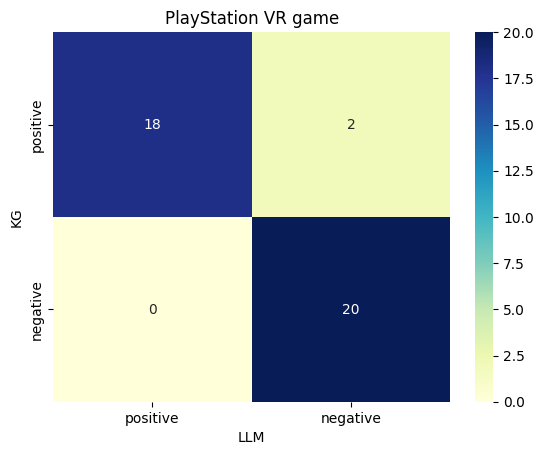

### LLM negative, KG positive

label,serialization,rationale
Gods (video game),"""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Strategy_First_games"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/The_Bitmap_Brothers_game"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_scored_by_David_Whittaker"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_scored_by_Richard_Joseph"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://www.w3.org/2002/07/owl#NamedIndividual"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/1991_video_game"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Amiga_game"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/DOS_game"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/MT-32-compatible_computer_game"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Mindscape_game"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/PC-98_game"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Platform_game"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Platform_game_series"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Single-player_video_game"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Super_Nintendo_Entertainment_System_game"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_based_on_Greek_mythology"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_developed_in_the_United_Kingdom"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_remakes_and_remastered_port"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Video_game_set_in_antiquity"" ""http://caligraph.org/resource/Gods_(video_game)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Wii_U_game""","Based on the provided definitions, there is no direct evidence or argument to assert that ""Gods (video game)"" is a PlayStation VR game. The definition of ""Gods (video game)"" does not include any information that categorizes it as a PlayStation VR game. The definition of a PlayStation VR game does not mention ""Gods (video game)"" as an instance of it. Therefore, without additional information or context, it cannot be concluded that ""Gods (video game)"" is a PlayStation VR game."
Eve Online,"""http://caligraph.org/resource/Eve_Online"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Space_opera_medium"" ""http://caligraph.org/resource/Eve_Online"" ""http:

## Newspaper in New South Wales (http://caligraph.org/ontology/Newspaper_in_New_South_Wales)

"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"	"http://www.w3.org/2000/01/rdf-schema#label"	"Newspaper in New South Wales"
"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Newspaper_published_in_Australia"
"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/List_of_newspapers_in_New_South_Wales"
"http://caligraph.org/resource/Imlay%20magnet_(19745643)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"
"http://caligraph.org/resource/Springwood%20Sentinel_(19750073)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"
"http://caligraph.org/resource/The%20Coastal%20Views_(19757798)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"
"http://caligraph.org/resource/The%20Gilgandra%20Weekly_(19778392)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"
"http://caligraph.org/resource/The%20Inverell%20Argus_(19753747)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"
"http://caligraph.org/resource/The%20St%20George%20Observer_(19771237)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"
"http://caligraph.org/resource/Duncan's%20weekly%20register%20of%20politics,%20facts%20and%20general%20literature_(19972099)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"
"http://caligraph.org/resource/Stageland_(19954562)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"
"http://caligraph.org/resource/The%20Moss%20Vale%20record_(19971389)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"
"http://caligraph.org/resource/Newcastle_Star"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"
"http://caligraph.org/resource/Tenterfield_Intercolonial_Courier_and_Fairfield_and_Wallangarra_Advocate"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"
"http://caligraph.org/resource/Moree_Champion"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"
"http://caligraph.org/resource/Dubbo"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"
"http://caligraph.org/resource/Oceania_(journal)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"
"http://caligraph.org/resource/The_Mirror_of_Australia"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"
"http://caligraph.org/resource/The_Northern_Times"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Newspaper_in_New_South_Wales"


### Confusion matrix

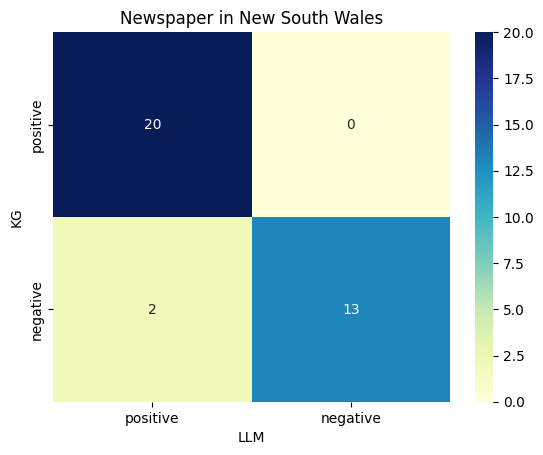

### LLM positive, KG negative

label,serialization,rationale
Parramatta Advertiser,"""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Newspaper_published_in_Sydney"" ""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://www.w3.org/2002/07/owl#NamedIndividual"" ""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://www.w3.org/2000/01/rdf-schema#label"" ""Parramatta Advertiser"" ""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://www.w3.org/2002/07/owl#sameAs"" ""http://dbpedia.org/resource/Parramatta_Advertiser"" ""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://www.w3.org/2004/02/skos/core#prefLabel"" ""Parramatta Advertiser"" ""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://caligraph.org/ontology/format"" ""http://caligraph.org/resource/Tabloid_(newspaper_format)"" ""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://caligraph.org/ontology/format"" ""http://caligraph.org/resource/Online_and_offline"" ""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://caligraph.org/ontology/foundingDate"" ""1933-07-15"" ""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://caligraph.org/ontology/headquarter"" ""http://caligraph.org/resource/Parramatta"" ""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://caligraph.org/ontology/headquarter"" ""http://caligraph.org/resource/Sydney"" ""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://caligraph.org/ontology/headquarter"" ""http://caligraph.org/resource/New_South_Wales"" ""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://caligraph.org/ontology/headquarter"" ""http://caligraph.org/resource/Australia"" ""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://caligraph.org/ontology/owner"" ""http://caligraph.org/resource/NewsLocal"" ""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://caligraph.org/ontology/type"" ""http://caligraph.org/resource/Newspaper"" ""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://caligraph.org/ontology/type"" ""http://caligraph.org/resource/Weekly_newspaper"" ""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://www.w3.org/ns/prov#wasDerivedFrom"" ""http://en.wikipedia.org/wiki/Category:Newspapers_published_in_Sydney"" ""http://caligraph.org/resource/Parramatta_Advertiser"" ""http://www.w3.org/ns/prov#wasDerivedFrom"" ""http://en.wikipedia.org/wiki/NewsLocal""","The Parramatta Advertiser is classified as a ""Newspaper published in Sydney"" according to the provided definition. Sydney is located in New South Wales, Australia. Therefore, if a newspaper is published in Sydney, it is also published in New South Wales. Hence, the Parramatta Advertiser can be considered a ""Newspaper in New South Wales""."
The Free Thought,"""http://caligraph.org/resource/The_Free_Thought"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Non-English-language_newspaper_published_in_Australia"" ""http://caligraph.org/resource/The_Free_Thought"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Newspaper_published_in_Sydney"" ""http://caligraph.org/resource/The_Free_Thought"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Ukrainian_publisher_(people)"" ""http://caligraph.org/resource/The_Free_Thought"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/1949_establishment_in_Australia"" ""http://caligraph.org/resource/The_Free_Thought"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://www.w3.org/2002/07/owl#NamedIndividual"" ""http://caligraph.org/resource/The_Free_Thought"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Publication_established_in_1949"" ""http://caligraph.org/resource/The_Free_Thought"" ""http://www.w3.o

## FK Sarajevo player (http://caligraph.org/ontology/FK_Sarajevo_player)

"http://caligraph.org/ontology/FK_Sarajevo_player"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/FK_Sarajevo_player"	"http://www.w3.org/2000/01/rdf-schema#label"	"FK Sarajevo player"
"http://caligraph.org/ontology/FK_Sarajevo_player"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/RestrictionHasValue_team_FK%20Sarajevo"
"http://caligraph.org/ontology/FK_Sarajevo_player"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Footballer_in_Bosnia_and_Herzegovina"
"http://caligraph.org/ontology/FK_Sarajevo_player"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Association_football_player_in_Bosnia_and_Herzegovina"
"http://caligraph.org/ontology/FK_Sarajevo_player"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:FK_Sarajevo_players"
"http://caligraph.org/ontology/FK_Sarajevo_player"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/List_of_FK_Sarajevo_players"
"http://caligraph.org/resource/Branislav%20Arsenijevi%C4%87_(19490760)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/FK_Sarajevo_player"
"http://caligraph.org/resource/Sead%20Jesenkovi%C4%87_(19501461)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/FK_Sarajevo_player"
"http://caligraph.org/resource/Darko_Raca"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/FK_Sarajevo_player"
"http://caligraph.org/resource/Franjo_Vuleta"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/FK_Sarajevo_player"
"http://caligraph.org/resource/Ibrahim_Biogradli%C4%87"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/FK_Sarajevo_player"
"http://caligraph.org/resource/Vule_Trivunovi%C4%87"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/FK_Sarajevo_player"
"http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/FK_Sarajevo_player"
"http://caligraph.org/resource/Vuka%C5%A1in_Vi%C5%A1njevac"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/FK_Sarajevo_player"
"http://caligraph.org/resource/Marko_Savi%C4%87_(footballer)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/FK_Sarajevo_player"
"http://caligraph.org/resource/Frank_Liivak"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/FK_Sarajevo_player"
"http://caligraph.org/resource/Matej_Kochan"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/FK_Sarajevo_player"
"http://caligraph.org/resource/Safet_Nadarevi%C4%87"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/FK_Sarajevo_player"
"http://caligraph.org/resource/Said_Fazlagi%C4%87"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/FK_Sarajevo_player"


### Confusion matrix

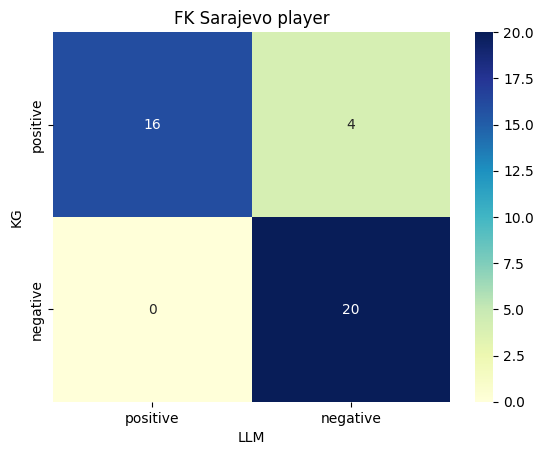

### LLM negative, KG positive

label,serialization,rationale
Sretko Vuksanović,"""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Bosnia_and_Herzegovina_expatriate_sportsperson_in_France"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://www.w3.org/2002/07/owl#NamedIndividual"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/1973_birth"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Association_football_midfielder"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Belgian_First_Division_A_player"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Belgian_First_Division_B_player"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Bosnia_and_Herzegovina_expatriate_footballer"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Bosnia_and_Herzegovina_expatriate_sportsperson_in_Belgium"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Expatriate_footballer_in_Belgium"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Expatriate_footballer_in_France"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/FC_Sochaux-Montb%C3%A9liard_player"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/K.A.A._Gent_player"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/K.R.C._Genk_player"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Ligue_1_player"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Living_person"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Royal_Cappellen_F.C._player"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/SC_Toulon_player"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Serb_of_Bosnia_and_Herzegovina"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Soccer_manager"" ""http://caligraph.org/resource/Sretko_Vuksanovi%C4%87"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Sportsperson_from_Sarajevo""","The assertion that Sretko Vuksanović is a FK Sarajevo player cannot be made based solely on the provided definition and information. While the definition does list Sretko Vuksanović as a footballer and provides various details about his career, it does not specifically state that he is or was a player for FK Sarajevo. Therefore, without additional information or context, the assertion cannot be made."
Tino-Sven Sušić,"""http://caligraph.org/resource/Tino-Sven_Su%C5%A1i%C4%87"" ""http://www.w3.org/1999/02/22-rdf-synt

## England under-21 international footballer (http://caligraph.org/ontology/England_under-21_international_footballer)

"http://caligraph.org/ontology/England_under-21_international_footballer"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/England_under-21_international_footballer"	"http://www.w3.org/2000/01/rdf-schema#label"	"England under-21 international footballer"
"http://caligraph.org/ontology/England_under-21_international_footballer"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/RestrictionHasValue_team_England%20national%20under-21%20football%20team"
"http://caligraph.org/ontology/England_under-21_international_footballer"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/England_youth_international_footballer"
"http://caligraph.org/ontology/England_under-21_international_footballer"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/National_under-21_association_football_team"
"http://caligraph.org/ontology/England_under-21_international_footballer"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:England_under-21_international_footballers"
"http://caligraph.org/resource/Garry_Parker"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/England_under-21_international_footballer"
"http://caligraph.org/resource/Patrick_Bamford"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/England_under-21_international_footballer"
"http://caligraph.org/resource/Paul_Gascoigne"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/England_under-21_international_footballer"
"http://caligraph.org/resource/Ray_Wilkins"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/England_under-21_international_footballer"
"http://caligraph.org/resource/Rod_Wallace"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/England_under-21_international_footballer"
"http://caligraph.org/resource/Brian_Atkinson"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/England_under-21_international_footballer"
"http://caligraph.org/resource/Chris_Woods"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/England_under-21_international_footballer"
"http://caligraph.org/resource/Daniel_Sturridge"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/England_under-21_international_footballer"
"http://caligraph.org/resource/Garry_Flitcroft"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/England_under-21_international_footballer"
"http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/England_under-21_international_footballer"
"http://caligraph.org/resource/Hayden_Mullins"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/England_under-21_international_footballer"
"http://caligraph.org/resource/Jason_Steele_(footballer)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/England_under-21_international_footballer"
"http://caligraph.org/resource/Martyn_Waghorn"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/England_under-21_international_footballer"
"http://caligraph.org/resource/Trevor_Benjamin"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/England_under-21_international_footballer"


### Confusion matrix

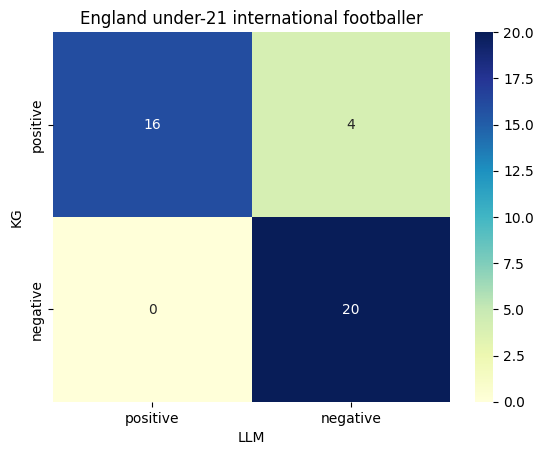

### LLM negative, KG positive

label,serialization,rationale
"Gary Mills (footballer, born 1961)","""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Alfreton_Town_F.C._player"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Northern_Premier_League_manager"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://www.w3.org/2002/07/owl#NamedIndividual"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/1961_birth"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Association_football_defender"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Association_football_midfielder"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Derby_County_F.C._player"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/English_Football_League_manager"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/English_Football_League_player"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/English_autobiographer"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/English_expatriate_footballer"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/English_expatriate_sportsperson_in_the_United_States"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/English_football_manager"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/English_footballer"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Expatriate_soccer_player_in_the_United_States"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Gresley_F.C._player"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Leicester_City_F.C._player"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Living_person"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Nottingham_Forest_F.C._player"" ""http://caligraph.org/resource/Gary_Mills_(footballer,_born_1961)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Notts_County_F.C._player""","The assertion that Gary Mills (footballer, born 1961) is an England under-21 international footballer can be supported by the information provided in the definition. According to the definition, an individual who is classified as an ""England under-21 international footballer"" is a

## Clube Náutico Capibaribe player (http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player)

"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"	"http://www.w3.org/2000/01/rdf-schema#label"	"Clube Náutico Capibaribe player"
"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/RestrictionHasValue_team_Clube%20N%C3%A1utico%20Capibaribe"
"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Footballer_in_Pernambuco"
"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:Clube_N%C3%A1utico_Capibaribe_players"
"http://caligraph.org/resource/Ives_(footballer)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"
"http://caligraph.org/resource/Marcel_(footballer,_born_August_1981)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"
"http://caligraph.org/resource/Vin%C3%ADcius_Eutr%C3%B3pio"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"
"http://caligraph.org/resource/David_(footballer,_born_1982)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"
"http://caligraph.org/resource/Yuri_Mamute"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"
"http://caligraph.org/resource/Claudio_Milar"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"
"http://caligraph.org/resource/Gladstone_(footballer)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"
"http://caligraph.org/resource/Jackson_(footballer,_born_1_May_1990)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"
"http://caligraph.org/resource/Renaldo_(footballer)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"
"http://caligraph.org/resource/Daniel_Bueno_(footballer)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"
"http://caligraph.org/resource/Eliomar_(footballer,_born_1987)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"
"http://caligraph.org/resource/Peter_(footballer,_born_1984)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"
"http://caligraph.org/resource/Hugo_Almeida_(Brazilian_footballer)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"
"http://caligraph.org/resource/Jo%C3%A3o_Ananias"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"
"http://caligraph.org/resource/Nivaldo_(footballer,_born_1980)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Clube_N%C3%A1utico_Capibaribe_player"


### Confusion matrix

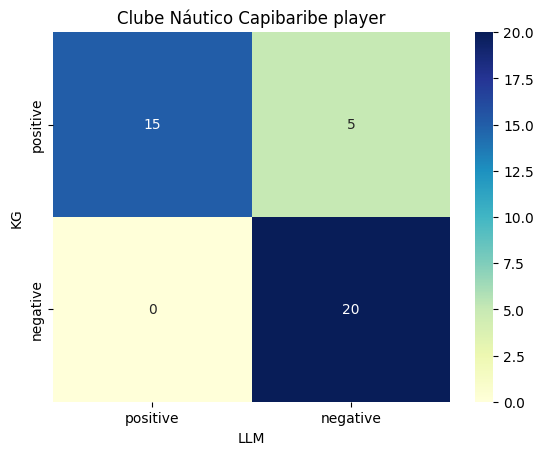

### LLM negative, KG positive

label,serialization,rationale
Renaldo (footballer),"""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/CF_Extremadura_footballer"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://www.w3.org/2002/07/owl#NamedIndividual"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/1970_birth"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Brazilian_expatriate_footballer"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Brazilian_expatriate_sportsperson_in_South_Korea"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Brazilian_expatriate_sportsperson_in_Spain"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Campeonato_Brasileiro_S%C3%A9rie_B_player"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Club_Athletico_Paranaense_player"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Clube_Atl%C3%A9tico_Mineiro_player"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Coritiba_Foot_Ball_Club_player"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Deportivo_de_La_Coru%C3%B1a_player"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Expatriate_footballer_in_South_Korea"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Expatriate_footballer_in_Spain"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/K_League_1_player"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/La_Liga_player"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Living_person"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Paran%C3%A1_Clube_player"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Segunda_Divisi%C3%B3n_player"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Sociedade_Esportiva_Palmeiras_player"" ""http://caligraph.org/resource/Renaldo_(footballer)"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Sport_Club_Corinthians_Paulista_player""","The definition provided does not contain any information or evidence to suggest that Renaldo (footballer) is a Clube Náutico Capibaribe player. The entity description for Renaldo (footballer) lists several teams that he has played for, but Clube Náutico Capibaribe is not among them. Therefore, based solely on the provided definition, we cannot assert that Renaldo (footballer) is a Clube Náutico Capibaribe player."
João Ananias,"""http://caligraph.org/resource/Jo%C3%A3o_Ananias"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns

## Romania international rugby union player (http://caligraph.org/ontology/Romania_international_rugby_union_player)

"http://caligraph.org/ontology/Romania_international_rugby_union_player"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/Romania_international_rugby_union_player"	"http://www.w3.org/2000/01/rdf-schema#label"	"Romania international rugby union player"
"http://caligraph.org/ontology/Romania_international_rugby_union_player"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/International_rugby_union_player"
"http://caligraph.org/ontology/Romania_international_rugby_union_player"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Romanian_rugby_union_player"
"http://caligraph.org/ontology/Romania_international_rugby_union_player"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/Category:Romania_international_rugby_union_players"
"http://caligraph.org/ontology/Romania_international_rugby_union_player"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/List_of_Romania_national_rugby_union_players"
"http://caligraph.org/resource/BucurAlexandru%20Bucur_(19466662)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Romania_international_rugby_union_player"
"http://caligraph.org/resource/Ion%20Costea_(19501326)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Romania_international_rugby_union_player"
"http://caligraph.org/resource/VasileVladimir%20Vasile_(19494281)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Romania_international_rugby_union_player"
"http://caligraph.org/resource/GiucalM.%20Giucal_(19746701)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Romania_international_rugby_union_player"
"http://caligraph.org/resource/ManoleGheorghe%20Manole_(19753782)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Romania_international_rugby_union_player"
"http://caligraph.org/resource/FuicuSorin%20Fuicu_(19970815)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Romania_international_rugby_union_player"
"http://caligraph.org/resource/NistorVasile%20Nistor_(19976819)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Romania_international_rugby_union_player"
"http://caligraph.org/resource/PasacheGeorge%20Pasache_(19964788)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Romania_international_rugby_union_player"
"http://caligraph.org/resource/VargaVasile%20Varga_(19981370)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Romania_international_rugby_union_player"
"http://caligraph.org/resource/C%C4%83t%C4%83lin_Nicolae"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Romania_international_rugby_union_player"
"http://caligraph.org/resource/Piti_(footballer)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Romania_international_rugby_union_player"
"http://caligraph.org/resource/Nicolae_R%C4%83cean"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Romania_international_rugby_union_player"
"http://caligraph.org/resource/Gabriel_Rupanu"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Romania_international_rugby_union_player"
"http://caligraph.org/resource/Jody_Rose"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Romania_international_rugby_union_player"


### Confusion matrix

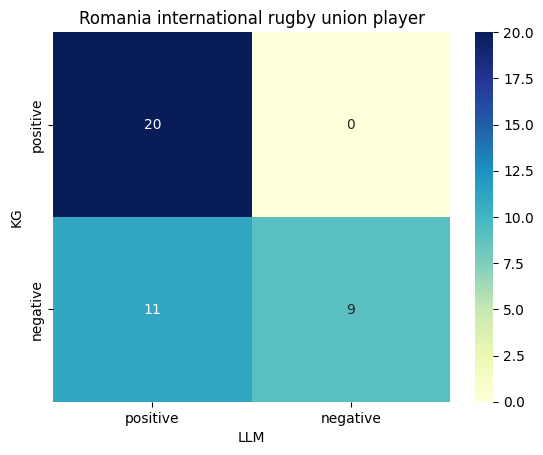

### LLM positive, KG negative

label,serialization,rationale
Iosif Nemes,"""http://caligraph.org/resource/Iosif_Nemes"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://www.w3.org/2002/07/owl#NamedIndividual"" ""http://caligraph.org/resource/Iosif_Nemes"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/1903_birth"" ""http://caligraph.org/resource/Iosif_Nemes"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Medalist_at_the_1924_Summer_Olympics"" ""http://caligraph.org/resource/Iosif_Nemes"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Olympic_bronze_medalist_for_Romania"" ""http://caligraph.org/resource/Iosif_Nemes"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Olympic_rugby_union_player_of_Romania"" ""http://caligraph.org/resource/Iosif_Nemes"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Romanian_rugby_union_player"" ""http://caligraph.org/resource/Iosif_Nemes"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Rugby_union_player_at_the_1924_Summer_Olympics"" ""http://caligraph.org/resource/Iosif_Nemes"" ""http://www.w3.org/2000/01/rdf-schema#label"" ""Iosif Nemes"" ""http://caligraph.org/resource/Iosif_Nemes"" ""http://www.w3.org/2002/07/owl#sameAs"" ""http://dbpedia.org/resource/Iosif_Nemes"" ""http://caligraph.org/resource/Iosif_Nemes"" ""http://www.w3.org/2004/02/skos/core#prefLabel"" ""Iosif Nemes"" ""http://caligraph.org/resource/Iosif_Nemes"" ""http://caligraph.org/ontology/birthYear"" ""1903"" ""http://caligraph.org/resource/Iosif_Nemes"" ""http://www.w3.org/ns/prov#wasDerivedFrom"" ""http://en.wikipedia.org/wiki/Category:Olympic_rugby_union_players_of_Romania"" ""http://caligraph.org/resource/Iosif_Nemes"" ""http://www.w3.org/ns/prov#wasDerivedFrom"" ""http://en.wikipedia.org/wiki/Category:Romanian_rugby_union_players"" ""http://caligraph.org/resource/Iosif_Nemes"" ""http://www.w3.org/ns/prov#wasDerivedFrom"" ""http://en.wikipedia.org/wiki/Category:Rugby_union_players_at_the_1924_Summer_Olympics"" ""http://caligraph.org/resource/Iosif_Nemes"" ""http://www.w3.org/ns/prov#wasDerivedFrom"" ""http://en.wikipedia.org/wiki/Category:1903_births"" ""http://caligraph.org/resource/Iosif_Nemes"" ""http://www.w3.org/ns/prov#wasDerivedFrom"" ""http://en.wikipedia.org/wiki/Category:Medalists_at_the_1924_Summer_Olympics"" ""http://caligraph.org/resource/Iosif_Nemes"" ""http://www.w3.org/ns/prov#wasDerivedFrom"" ""http://en.wikipedia.org/wiki/Category:Olympic_bronze_medalists_for_Romania""","The definition of a ""Romania international rugby union player"" is a subclass of ""International rugby union player"" and ""Romanian rugby union player"". Iosif Nemes is classified as a ""Romanian rugby union player"" and an ""Olympic rugby union player of Romania"", which implies that he has played rugby at an international level for Romania. Therefore, based on the given definition, it can be argued that Iosif Nemes is a ""Romania international rugby union player""."
Gheorghe Gajion,"""http://caligraph.org/resource/Gheorghe_Gajion"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Moldovan_rugby_union_player"" ""http://caligraph.org/resource/Gheorghe_Gajion"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Stade_Aurillacois_Cantal_Auvergne_player"" ""http://caligraph.org/resource/Gheorghe_Gajion"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://www.w3.org/2002/07/owl#NamedIndividual"" ""http://caligraph.org/resource/Gheorghe_Gajion"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/1992_birth"" ""http://caligraph.org/resource/Gheorghe_Gajion"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/2020%E2%80%9321_Pro14_transfer"" ""http://caligraph.org/resource/Gheorghe_Gajion"" ""http://www.w3.o

## Member of the European Parliament, 1989–1994 (http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994)

"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://www.w3.org/2002/07/owl#Class"
"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"	"http://www.w3.org/2000/01/rdf-schema#label"	"Member of the European Parliament, 1989–1994"
"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"	"http://www.w3.org/2000/01/rdf-schema#subClassOf"	"http://caligraph.org/ontology/Member_of_the_European_Parliament_1989%E2%80%931994"
"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"	"http://www.w3.org/ns/prov#wasDerivedFrom"	"http://en.wikipedia.org/wiki/List_of_members_of_the_European_Parliament,_1989%E2%80%931994"
"http://caligraph.org/resource/Arturo%20Juan%20Escuder%20Croft_(19470996)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"
"http://caligraph.org/resource/Carlos%20Mar%C3%ADa%20Bru%20Pur%C3%B3n_(19504251)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"
"http://caligraph.org/resource/Florus%20Wijsenbeek_(19476130)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"
"http://caligraph.org/resource/Fr%C3%A9d%C3%A9ric%20Rosmini_(19471527)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"
"http://caligraph.org/resource/Nora%20Mebrak-Za%C3%AFdi_(19485342)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"
"http://caligraph.org/resource/Marie-Christine%20Aulas_(19763634)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"
"http://caligraph.org/resource/Eusebio%20Cano%20Pinto_(19979264)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"
"http://caligraph.org/resource/Jos%C3%A9%20Manuel%20Torres%20Couto_(19979191)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"
"http://caligraph.org/resource/Doris_Pack"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"
"http://caligraph.org/resource/Jim_Fitzsimons"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"
"http://caligraph.org/resource/Richard_Simmonds"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"
"http://caligraph.org/resource/Robert_Krieps"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"
"http://caligraph.org/resource/Fernando_Gomes_(politician)"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"
"http://caligraph.org/resource/Philippe_Douste-Blazy"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"
"http://caligraph.org/resource/Francisco_Sanz_Fern%C3%A1ndez"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"
"http://caligraph.org/resource/Johanna_Grund"	"http://www.w3.org/1999/02/22-rdf-syntax-ns#type"	"http://caligraph.org/ontology/Member_of_the_European_Parliament,_1989%E2%80%931994"


### Confusion matrix

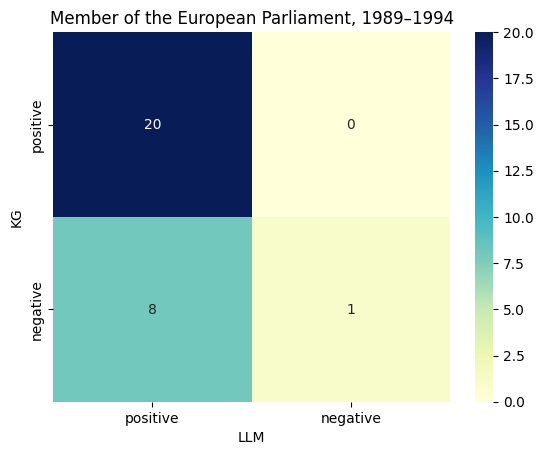

### LLM positive, KG negative

label,serialization,rationale
Dick Ukeiwé,"""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Senator_of_New_Caledonia"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Kanak_person"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/New_Caledonia_politician"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Person_from_the_Loyalty_Islands"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Black_French_politician"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://www.w3.org/2002/07/owl#NamedIndividual"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/1928_birth"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/2013_death"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/President_of_the_Congress_of_New_Caledonia"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Member_of_the_European_Parliament_for_France,_1989%E2%80%931994"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/2000/01/rdf-schema#label"" ""Dick Ukeiwé"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/2002/07/owl#sameAs"" ""http://dbpedia.org/resource/Dick_Ukeiw%C3%A9"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/2004/02/skos/core#prefLabel"" ""Dick Ukeiwé"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://caligraph.org/ontology/birthPlace"" ""http://caligraph.org/resource/Loyalty_Islands_Province"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://caligraph.org/ontology/birthPlace"" ""http://caligraph.org/resource/New_Caledonia"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://caligraph.org/ontology/birthYear"" ""1928"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://caligraph.org/ontology/deathYear"" ""2013"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/ns/prov#wasDerivedFrom"" ""http://en.wikipedia.org/wiki/Category:Black_French_politicians"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/ns/prov#wasDerivedFrom"" ""http://en.wikipedia.org/wiki/List_of_members_of_the_European_Parliament_for_France,_1989%E2%80%931994"" ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/ns/prov#wasDerivedFrom"" ""http://en.wikipedia.org/wiki/Category:New_Caledonia_politicians""","The assertion that Dick Ukeiwé is a Member of the European Parliament, 1989–1994 can be supported by the information provided in the entity description. Specifically, the line: ""http://caligraph.org/resource/Dick_Ukeiw%C3%A9"" ""http://www.w3.org/1999/02/22-rdf-syntax-ns#type"" ""http://caligraph.org/ontology/Member_of_the_European_Parliament_for_France,_1989%E2%80%931994"" This line indicates that Dick Ukeiwé is classified under the type ""Member of the European Parliament for France, 1989–1994"". Given that the concept ""Member of the European Parliament, 1989–1994"" would logically include all members of the European Parliament during that period, regardless of their country of representation, it can be inferred that Dick Ukeiwé, as a member of the European Parliament for France during that period, would also be a member of the broader category ""Member of the European Parliament, 1989–1994""."
L

In [9]:
for experiment in experiment_df["experiment"].values:
    display_experiment(experiment)